# Lane detection Project

## important imports

In [1]:
import os
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sqlalchemy import true
%matplotlib inline

## Global variables

In [2]:
prev_leftx=np.zeros(720, np.float32)
prev_lefty=np.zeros(720, np.float32)
left_fitx_prev=np.zeros(720, np.float32)
right_fitx_prev=np.zeros(720, np.float32)
prev_curve_l=6000
prev_curve_r=6000
flag=1
first=1

## 1. Compute the camera calibration sing chessboard images

### 1.1. Generate object points and image points

In [3]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(r'camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    # Read in a calibration image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add objects points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

### 1.2. Compute the camera calibration given points and image points

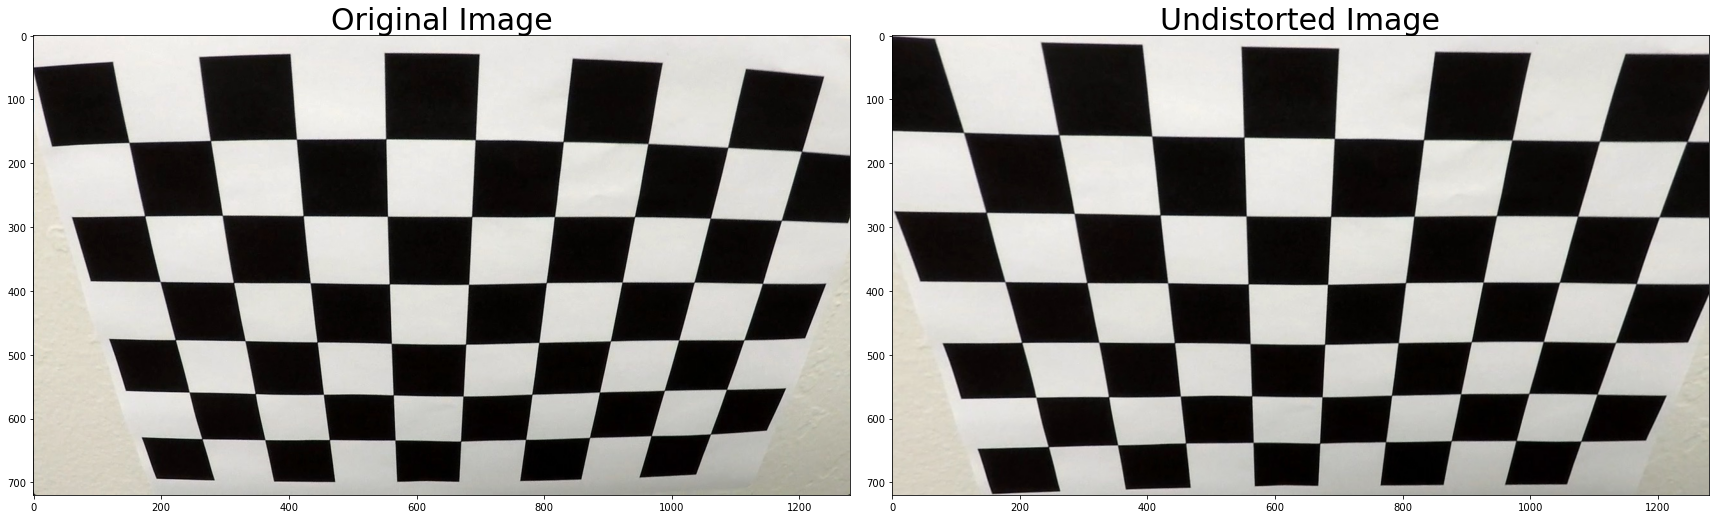

In [4]:
# Test undistortion on an image
img = mpimg.imread(r'camera_cal\calibration2.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistort a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\calibration.jpg')

### 1.3. Apply distortion correction to raw images

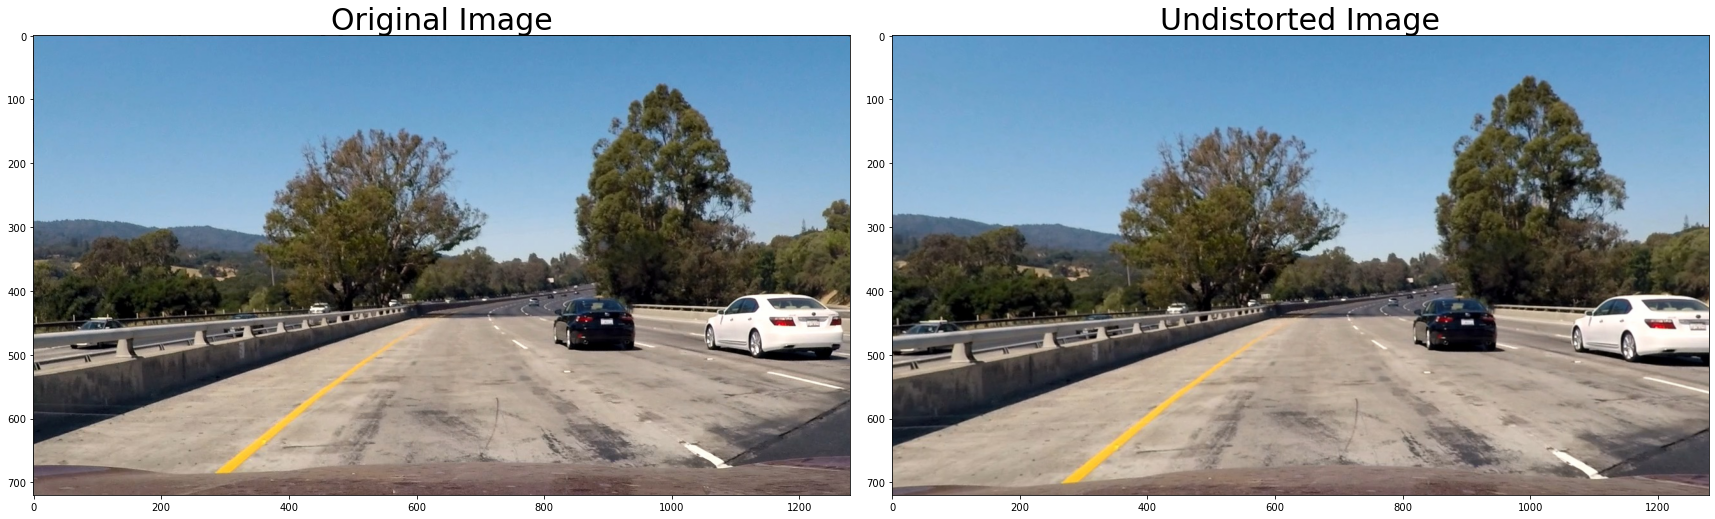

In [5]:
# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\distortion.jpg')

## 2. Create a thresholded binary image

### 2.1. Define function to get lane edges using color transformations 

In [6]:
def channel_thresh(img):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Convert image to HSV color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    # Threshold selected channel l to detect right lane
    L_max=np.amax(L)
    right_lane_photo = np.zeros_like(L)
    #Apply relative thresholds to the maximum value of channel L
    right_lane_photo[(L >= 0.8*L_max) & (L <= 1*L_max)] = 1
    left_lane_photo_h = np.zeros_like(H)
    #Apply the yellow color thershold to channel H to detect left lane
    left_lane_photo_h[(H >= 20) & (H <= 30)] = 1
    
    #Apply relative thresholds to the maximum value of channel V to detect left lane
    left_lane_photo_v = np.zeros_like(V)
    V_max=np.amax(V)
    left_lane_photo_v[(V >= 0.58*V_max) & (V <= 1*V_max)] = 1
    left_lane_photo = np.zeros_like(V)
    left_lane_photo=left_lane_photo_v&left_lane_photo_h
    
    # Create 2 binary channels for left & right lanes
    return left_lane_photo , right_lane_photo

### 2.2. Test `channel_thresh` with a single raw image

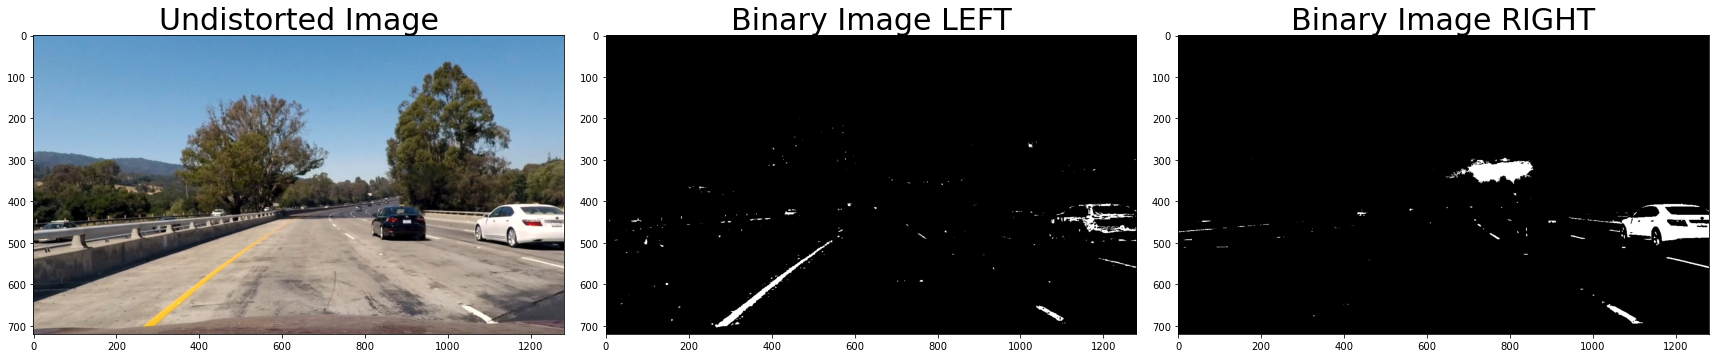

In [7]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
left_lane_edges,right_lane_edges = channel_thresh(dst)


# Visualize undistortion
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(left_lane_edges, cmap='gray')
ax2.set_title('Binary Image LEFT', fontsize=30)
ax3.imshow(right_lane_edges, cmap='gray')
ax3.set_title('Binary Image RIGHT', fontsize=30)
plt.savefig(r'output_images\binary.jpg')

## 3. Apply a perspective transform to rectify binary images

### 3.1. Compute a perspective transform using images with straight lane lines

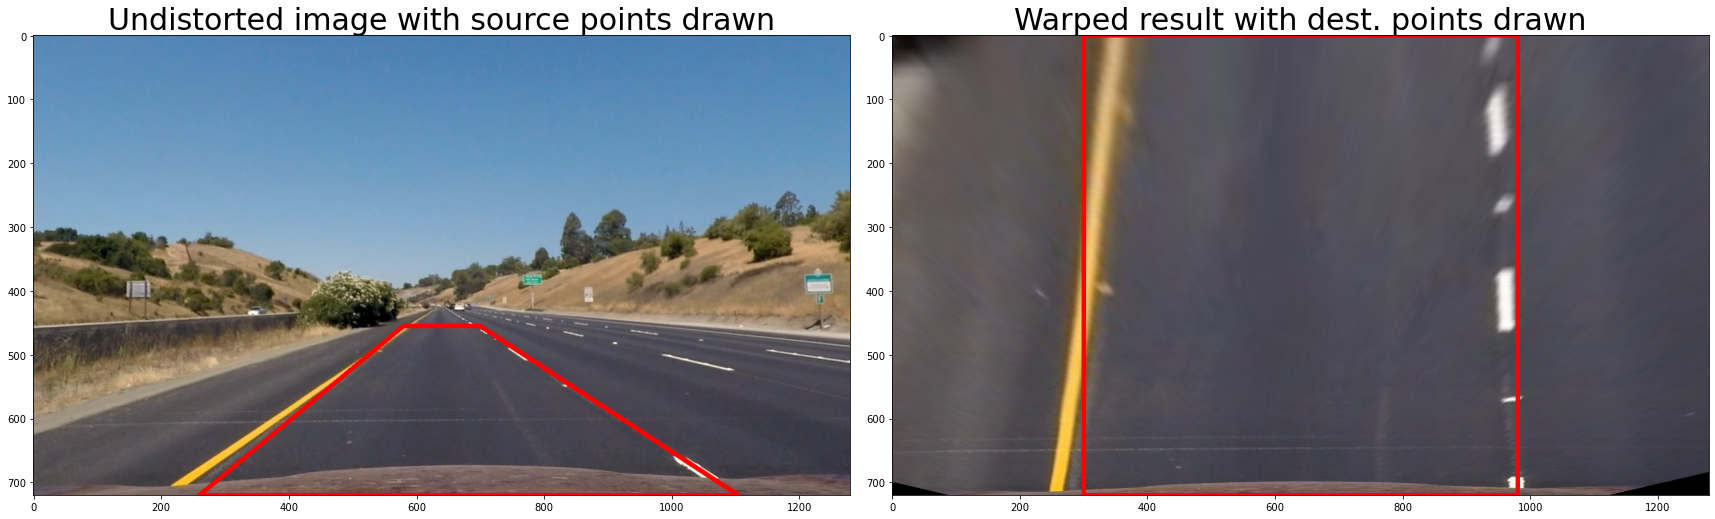

In [8]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Four source coordinates
src = np.array([[260, 720],[580, 455],[700, 455],[1105, 720]], dtype=np.float32)

# Reduce the width of the image by offset to form a rectangle
offset = 300

# Four destination coordinates
dst = np.array([[offset, img.shape[0]], 
                [offset, 0], 
                [img.shape[1] - offset, 0], 
                [img.shape[1] - offset, img.shape[0]]], dtype=np.float32)

# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the perspective transform result for later use
pers_pickle = {}
pers_pickle['M'] = M
pers_pickle['Minv'] = Minv
pickle.dump(pers_pickle, open('pers_pickle.p', 'wb'))

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Draw source and destination points over images
undist = cv2.polylines(undist, [src.astype(np.int32)], True, (255, 0, 0), thickness=5)
warped = cv2.polylines(warped, [dst.astype(np.int32)], True, (255, 0, 0), thickness=5)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped result with dest. points drawn', fontsize=30)
plt.savefig(r'output_images\perspective.jpg')

### 3.2. Apply a perspective transform to images with curved lines

Text(0.5, 1.0, 'Warped combined lanes result with dest. points drawn')

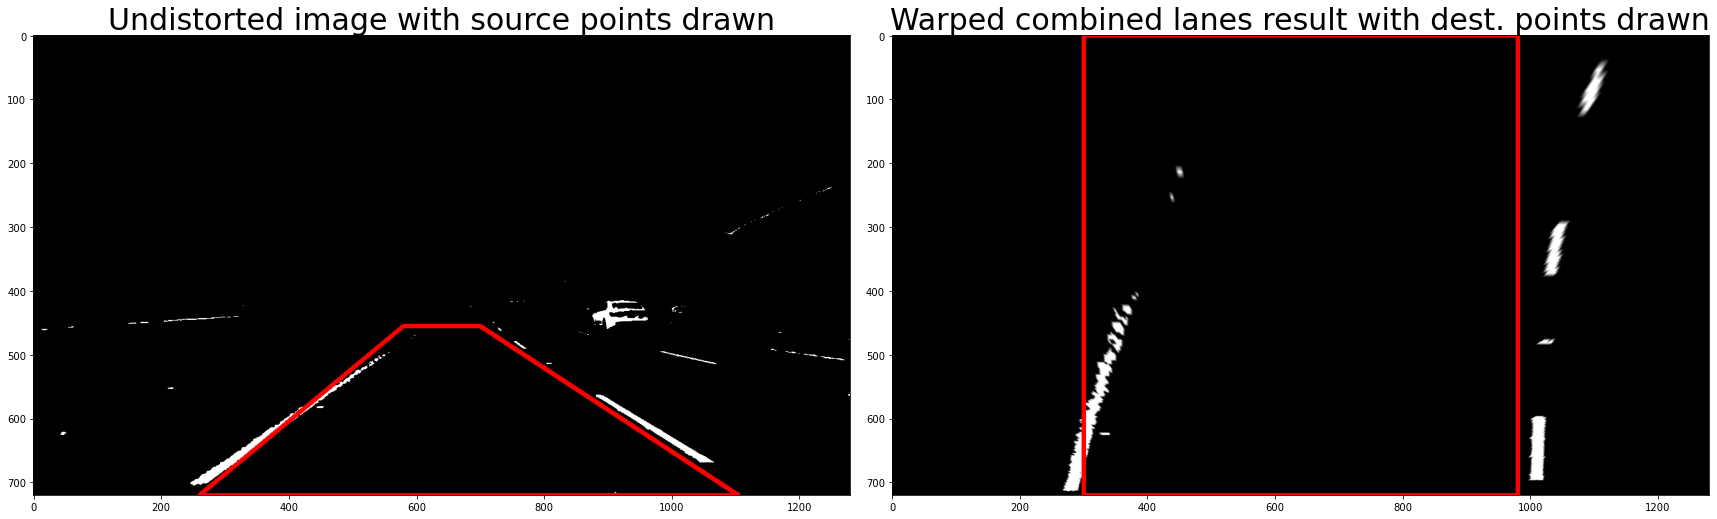

In [9]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\test3.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
left_lane_edges,right_lane_edges = channel_thresh(undist)
binary_image=left_lane_edges|right_lane_edges
undist = np.dstack((binary_image, binary_image, binary_image))*255

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Draw source and destination points over images
undist = cv2.polylines(undist, [src.astype(np.int32)], True, (255, 0, 0), thickness=5)
warped = cv2.polylines(warped, [dst.astype(np.int32)], True, (255, 0, 0), thickness=5)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist, cmap='gray')
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped combined lanes result with dest. points drawn', fontsize=30)

## 4. Finding the lines

### 4.1. Define functions to implement sliding windows and get lines as polynomial

In [10]:
def apply_sliding_windows(binary_warped_l,binary_warped_r, nwindows=9, margin=100, minpix=55):
    #binary_warped_l&binary_warped_r are the edges detected for left and right lanes
    global prev_leftx,prev_lefty,prev_rightx,prev_righty,flag
    # Take a histogram of the bottom half of the image
    histogram_l = np.sum(binary_warped_l[binary_warped_l.shape[0]//2:,:], axis=0)
    histogram_r = np.sum(binary_warped_r[binary_warped_r.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(binary_warped_l.shape[0]//2)
    leftx_base = np.argmax(histogram_l[:midpoint])
    rightx_base = np.argmax(histogram_r[midpoint:]) + midpoint
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped_l, binary_warped_l, binary_warped_l))
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_l.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    #Get 2 lists of indices containing rows & cols of non-zero elements respc
    nonzero_l = binary_warped_l.nonzero()
    nonzero_r = binary_warped_r.nonzero()
    #Get coordinates of non-zero pixels
    nonzeroy_l = np.array(nonzero_l[0])
    nonzerox_l = np.array(nonzero_l[1])
    nonzeroy_r = np.array(nonzero_r[0])
    nonzerox_r = np.array(nonzero_r[1])
    
    # Current positions to be updated later for each window in nwindows
    #initialy at position of most pixels
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Indentify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_l.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_l.shape[0] - window*window_height
        
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ( (nonzeroy_l >= win_y_low)     & 
                           (nonzeroy_l <  win_y_high)    & 
                           (nonzerox_l >= win_xleft_low) & 
                           (nonzerox_l <  win_xleft_high)).nonzero()[0]
        
        good_right_inds = ( (nonzeroy_r >= win_y_low)      & 
                            (nonzeroy_r <  win_y_high)     & 
                            (nonzerox_r >= win_xright_low) & 
                            (nonzerox_r <  win_xright_high)).nonzero()[0]
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If the number of pixels found > minpix pixels which means that the lane is curved, recenter next window
        # ('rightx_current' or 'leftx_current') on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox_l[good_left_inds]))
       
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox_r[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions

    leftx  = nonzerox_l[left_lane_inds]
    lefty  = nonzeroy_l[left_lane_inds] 
    rightx = nonzerox_r[right_lane_inds]
    righty = nonzeroy_r[right_lane_inds]
   
    #if leftx is empty means no left lane is not detected or erased from ground so assume the lane edge is same as the pre frame
    if (leftx.size==0):
        leftx=prev_leftx
        lefty=prev_lefty
    else : #else update the lane points to be used later when no lane is detected
        prev_leftx=leftx
        prev_lefty=lefty
    #if rightx is empty means no left lane is not detected or erased from ground so assume the lane edge is same as the pre frame
    if (rightx.size==0):
        rightx=prev_rightx
        righty=prev_righty
    else : #else update the lane points to be used later when no lane is detected
        prev_rightx=rightx
        prev_righty=righty
        
    
    # return lan points detected by the windows for the left & right also an image containing winows track
    return leftx, lefty, rightx, righty,out_img


def get_lines_as_polynomial(binary_warped_l,binary_warped_r):
    #binary_warped_l&binary_warped_r are the edges detected for left and right lanes
    global left_fitx_prev ,right_fitx_prev,prev_curve_l,prev_curve_r,flag,first
    # Find our lane pixels first
    leftx, lefty, rightx, righty,out_image = apply_sliding_windows(binary_warped_l,binary_warped_r)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_l.shape[0]-1, binary_warped_l.shape[0] )
    # Fit a second order polynomial to each using 'np.polyfit'
    #return list of coefs
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #compute the curve value for all points according to the calculated coefs and lane pixels
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Get current raduis of curvature of the 2 lanes
    _,_,left_curverad,right_curverad=measure_curvature_real(ploty, left_fitx, right_fitx)
    #Compare current raduis of curvature of the 2 lanes
    detect_error_precentage= (np.abs(left_curverad-right_curverad)/(left_curverad+right_curverad))*100

    if (detect_error_precentage>50) and not (first<4): # if the error of between the 2 lanes is high so there is violent change in lanes which is realstic and happened due to noise
        flag=0
    else:
        first+=1
    if flag==0 :
        flag=1
        #Use lane pixels if the prev frame
        left_fitx=left_fitx_prev
        right_fitx=right_fitx_prev
    else:
        right_fitx_prev=right_fitx
        left_fitx_prev=left_fitx


    # Visualization of lane pixels detected by the sliding windows
    # Colors in the left and right lane regions
    out_image[lefty, leftx] = [255, 0, 0]
    out_image[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    verts = np.array(list(zip(left_fitx.astype(int),ploty.astype(int))))
    out_image=cv2.polylines(out_image,[verts],False,(0,255,255),thickness=10)
    verts = np.array(list(zip(right_fitx.astype(int),ploty.astype(int))))
    out_image=cv2.polylines(out_image,[verts],False,(0,255,255),thickness=10)
    
    
    return ploty, left_fitx, right_fitx,out_image


def fit_polynomial(binary_warped_l,binary_warped_r):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = apply_sliding_windows(binary_warped_l,binary_warped_r)
   
    # Fit a second order polynomial to each using 'np.polyfit'
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_l.shape[0]-1, binary_warped_l.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if 'left' and 'right_fit' are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    verts = np.array(list(zip(left_fitx.astype(int),ploty.astype(int))))
    out_img=cv2.polylines(out_img,[verts],False,(255,255,0),thickness=6)
    verts = np.array(list(zip(right_fitx.astype(int),ploty.astype(int))))
    out_img=cv2.polylines(out_img,[verts],False,(255,255,0),thickness=6)
    return out_img

## 4.2. Test functions  sliding windows and fit_polynomial

C:\Users\dell\AppData\Local\Temp/ipykernel_16220/976708740.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(binary_warped_l.shape[0]//2)
C:\Users\dell\AppData\Local\Temp/ipykernel_16220/976708740.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

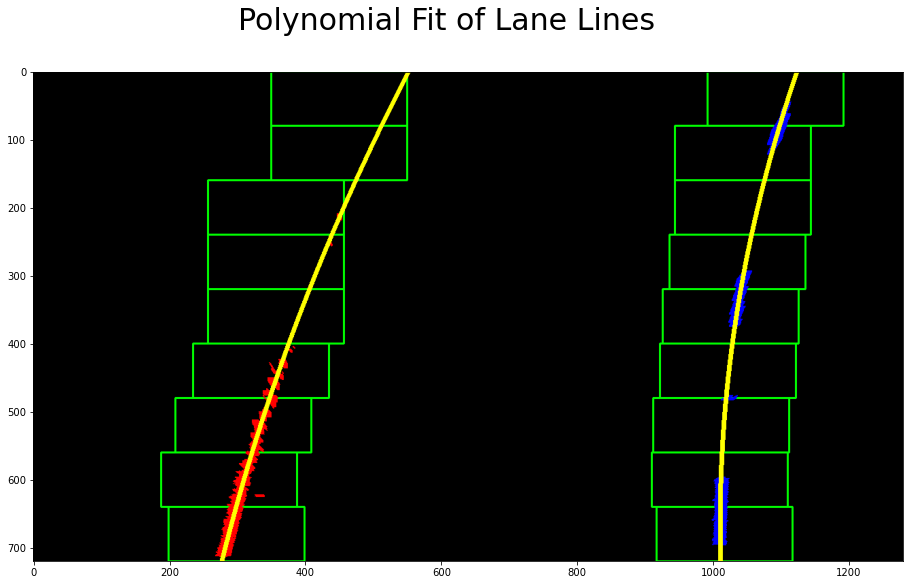

In [11]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\test3.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
left_lane,right_lane = channel_thresh(undist)
warped_l = cv2.warpPerspective(left_lane, M, img_size, flags=cv2.INTER_LINEAR)
warped_r = cv2.warpPerspective(right_lane, M, img_size, flags=cv2.INTER_LINEAR)

# Warp an image using the perspective transform, M:
#warped = cv2.warpPerspective(thresh, M, img_size, flags=cv2.INTER_LINEAR)

# Implements sliding windows and fits a polynomial
fig = plt.figure(figsize=(24, 9))
fig.suptitle('Polynomial Fit of Lane Lines', fontsize=30)
out_image =  fit_polynomial(warped_l,warped_r)
plt.imshow(out_image)
plt.savefig(r'output_images\polynomial.jpg')

# 

## 5. Determine the curvature of the lane and vehicle position

In [12]:
def measure_curvature_real(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to real world positions in each lane lines
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    
    # Implement the calculation of radius of curvature
    t1=2*left_fit_cr[0]
    t2=2*right_fit_cr[0]
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(t1)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(t2)
    left_curverad_s = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / t1
    right_curverad_s = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / t2
    
    return left_curverad, right_curverad ,left_curverad_s ,right_curverad_s

def measure_position_real(img_size, ploty, leftx, rightx):
    '''
    Calculates the distance from the center position in meters.
    '''
    # Determine the dimension of the image
    y_max = img_size[0]
    x_max = img_size[1]
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane lines
    left_fit  = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    leftx_pos  = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    
    lanex_center = (leftx_pos + rightx_pos)//2
    
    result = ((x_max // 2) - lanex_center) * xm_per_pix
    
    return result

def project_measurements(image, binary_warped_l,binary_warped_r, Minv):
    #get points on the left & right lanes and windows track on lanes image
    ploty, left_fitx, right_fitx,out_img_window = get_lines_as_polynomial(binary_warped_l,binary_warped_r)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_l).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image in green 
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Plots the left and right polynomials on the lane lines
    color_warp2=np.dstack((warp_zero, warp_zero, warp_zero))
    verts = np.array(list(zip(left_fitx.astype(int),ploty.astype(int))))
    color_warp2=cv2.polylines(color_warp2,[verts],False,(255,0,0),thickness=30)
    verts = np.array(list(zip(right_fitx.astype(int),ploty.astype(int))))
    color_warp2=cv2.polylines(color_warp2,[verts],False,(0,0,255),thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp2 = cv2.warpPerspective(color_warp2, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the region between lanes with the original image
    out_image = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # # Combine the result with the lanes iteself with higher weight for better visiability
    out_image = cv2.addWeighted(out_image, 1, newwarp2, 0.6, 0)

    
    
    # Calculate the curvature of polynomial functions in meters
    left_curverad, right_curverad ,_,_= measure_curvature_real(ploty, left_fitx, right_fitx)
    
    # Calculate the mean and draw the radius of curvature on the image
    curvature = int(np.mean([left_curverad, right_curverad]))
    cv2.putText(out_image, 'Radius of Curvature = {:4d}(m)'.format(curvature), (40, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Calculate the vehicle position relative to center
    position = measure_position_real(out_image.shape, ploty, left_fitx, right_fitx)
    
    # Draw the vehicle position on the image
    side = 'left' if position < 0 else 'right'
    cv2.putText(out_image, 'Vehicle is {:.2f}(m) {} of center'.format(abs(position), side), (40, 110), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    return out_image,out_img_window


# 5.1. Test Project measurements

C:\Users\dell\AppData\Local\Temp/ipykernel_16220/976708740.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(binary_warped_l.shape[0]//2)
C:\Users\dell\AppData\Local\Temp/ipykernel_16220/976708740.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

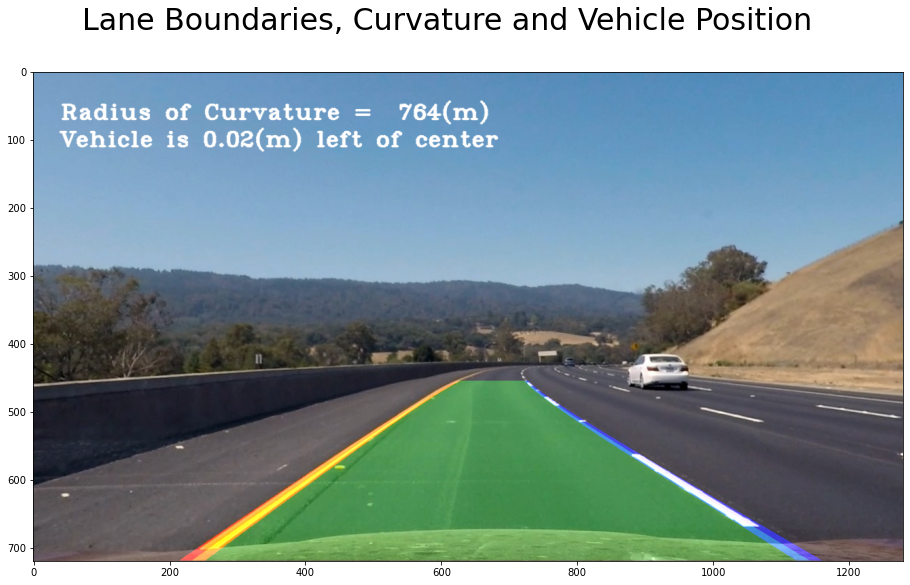

In [13]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to raw image
img = mpimg.imread(r'test_images\test3.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
thresh_l,thresh_r = channel_thresh(undist)

# Warp an image using the perspective transform, M:
warped_l = cv2.warpPerspective(thresh_l, M, img_size, flags=cv2.INTER_LINEAR)
warped_r = cv2.warpPerspective(thresh_r, M, img_size, flags=cv2.INTER_LINEAR)

# Project the lane boundaries, curvature and vehicle position onto the undistorted image
out_img,out_img_window = project_measurements(undist,warped_l,warped_r, Minv)

fig = plt.figure(figsize=(24, 9))
fig.suptitle('Lane Boundaries, Curvature and Vehicle Position', fontsize=30)
plt.imshow(out_img)
plt.savefig(r'output_images\projection.jpg')

## Test Pipeline in the Project Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

## Function to combine all stages output in one frame

In [ ]:
def pipline_outputs_combined(main_frame,stages_output):
    #Get the orginal frame height
    h1, w1 = main_frame.shape[:2]
    #Get pipeline output images size
    square_size=int(h1/len(stages_output))        
    img_3 = np.zeros((h1, w1+square_size,3), dtype=np.uint8)
    img_3[:h1, :w1,:3] = main_frame
    i=0
    #Add pipeline output images to the original frame
    for image in stages_output:
        image=cv2.resize(image,(square_size,square_size),interpolation = cv2.INTER_AREA)
        img_3[i*square_size:(i*square_size)+square_size, w1:w1+square_size,:3] = image
        i+=1

    return img_3

In [ ]:
def process_image_debug(img):
    # Determine the size of the image
    img_size = (img.shape[1], img.shape[0])
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    # Create a thresholded binary image
    thresh_l,thresh_r = channel_thresh(undist)

    # Warp an image using the perspective transform, M:
    warped_l = cv2.warpPerspective(thresh_l, M, img_size, flags=cv2.INTER_LINEAR)
    warped_r = cv2.warpPerspective(thresh_r, M, img_size, flags=cv2.INTER_LINEAR)
    warped_l_2 = np.dstack((warped_l, warped_l, warped_l))*255
    warped_r_2 = np.dstack((warped_r, warped_r, warped_r))*255

    # Project the lane boundaries, curvature and vehicle position onto the undistorted image
    out_img,out_window_img = project_measurements(undist,  warped_l,warped_r, Minv)
   
    
    return pipline_outputs_combined(out_img,[warped,warped_l_2,warped_r_2,out_window_img]) 
def process_image(img):
    # Determine the size of the image
    img_size = (img.shape[1], img.shape[0])
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Create a thresholded binary image
    thresh_l,thresh_r = channel_thresh(undist)

    # Warp an image using the perspective transform, M:
    warped_l = cv2.warpPerspective(thresh_l, M, img_size, flags=cv2.INTER_LINEAR)
    warped_r = cv2.warpPerspective(thresh_r, M, img_size, flags=cv2.INTER_LINEAR)

    # Project the lane boundaries, curvature and vehicle position onto the undistorted image
    out_img,out_img_window = project_measurements(undist,warped_l,warped_r, Minv)
   
    
    return out_img

# 4.2. Test Code and choose mode of operation

In [ ]:
#Debugging mode
debug_mode=True
#Output video
video_output = 'project_video_output_debug.mp4'

if debug_mode:
    #Input video
    clip1 = VideoFileClip("project_video.mp4")
    output_clip = clip1.fl_image(process_image_debug) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(video_output, audio=False)
else:
    clip1 = VideoFileClip("project_video.mp4")
    output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(video_output, audio=False)
     

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))